In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from hamming_distance_distribution import hamming_distance
from annealing import solve_annealing, adjacency_from_couplings, modify_coupling_matrix, get_groundstate
from telecom import get_ising_parameters
from graph import is_connected

In [2]:
def annealing_by_connection_g(N_repeat, N, M, alpha, K, xi, neglection_thres, gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time):
    """Annealing processes are done and the number of correct annealing results is counted.
    Depending on the type of graph (connected or unconnected), the results are counted separately.

    Returns:
    - N_correct_connected   number of correct detections when the graph was connected
    - N_correct_unconnected number of correct detections when the graph was unconnected
    """
    alpha = np.array(alpha, dtype=int)          # important to force the type to int because otherwise the bitwise xor in hamming_distance doesn't work

    N_correct_connected     = 0
    N_correct_unconnected   = 0
    N_connected             = 0
    N_unconnected           = 0

    for _ in range(N_repeat):
        # annealing
        J, b, *_ = get_ising_parameters(N, M, alpha, K, xi, False)
        J_n, _ = modify_coupling_matrix(J, 1, neglection_thres, False)
        _, _, _, _, _, _, _, _, Hscheduled1 = solve_annealing(J_n, b, gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time, False)
        _, _, gs_array1 = get_groundstate(Hscheduled1, 1)

        # classify annealing result
        d_Hamming = hamming_distance(alpha, gs_array1)
        connected = is_connected(adjacency_from_couplings(J_n))

        if connected:
            N_connected += 1
            if d_Hamming==0:
                N_correct_connected += 1

        if not connected:
            N_unconnected += 1
            if d_Hamming==0:
                N_correct_unconnected += 1

    return N_correct_connected, N_correct_unconnected, N_connected, N_unconnected


In [3]:
# --------- Parameters ---------
N_repeat = 100      # how many values per neglection thresold (corresponds to resolution of y axis)
N_stat = 10         # how often to repeat annealing_by_connection in order to obtain an average and errorbars

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

which_ctl_fct = 0   # 0: linear control function, 1: optimal control function
neglection_thres = [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]

nb_pts_gap = 20     # number of points for the gap computation
nb_pts_time = 30    # number of points for resolution of the time dependant Schrodinger's equation
epsilon = 0.1       # precision level for the control function (valid for both, linear and optimal scheduling)
gamma = 1           # strength of the transverse field, irrelevant for us 

In [4]:
# ----------- Program -------------
neglection_thres = np.array(neglection_thres)

# activity pattern
alpha = np.zeros(N)
alpha[0] = 1
alpha[1] = 1

# runtime estimation 
t0 = time.time()
_ = annealing_by_connection_g(N_repeat, N, M, alpha, K, xi, neglection_thres[0], gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time)
t1 = time.time()
t_run_est = (t1-t0)*N_stat*len(neglection_thres)
print(f"Estimated runtime: {t_run_est/60:.2f} min")

# generate data
N_correct_connected     = np.zeros(shape=(len(neglection_thres), N_stat))
N_correct_unconnected   = np.zeros(shape=(len(neglection_thres), N_stat))
N_connected             = np.zeros(shape=(len(neglection_thres), N_stat))
N_unconnected           = np.zeros(shape=(len(neglection_thres), N_stat))


for i in range(len(neglection_thres)):
    for j in range(N_stat):
        result = annealing_by_connection_g(N_repeat, N, M, alpha, K, xi, neglection_thres[i], gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time)    
        N_correct_connected[i, j]   = result[0]
        N_correct_unconnected[i, j] = result[1]
        N_connected[i, j]           = result[2]
        N_unconnected[i, j]         = result[3]
t2 = time.time()



Estimated runtime: 51.98 min


/home/fabian/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : 

In [5]:
print(f"The program took {(t2-t1)/60:.2f} min")

# ratios
r_correct_connected     = N_correct_connected   /   N_connected
r_correct_unconnected   = N_correct_unconnected /   N_unconnected

The program took 50.05 min


In [6]:
# statistics
r_correct_connected_mean    = np.mean(r_correct_connected, axis=1)
dr_correct_connected        = np.std(r_correct_connected, axis=1)
dr_mean_correct_connected   = dr_correct_connected / np.sqrt(N_stat)

r_correct_unconnected_mean  = np.mean(r_correct_unconnected, axis=1)
dr_correct_unconnected      = np.std(r_correct_unconnected, axis=1)
dr_mean_correct_unconnected = dr_correct_unconnected / np.sqrt(N_stat)

total number of runs per neglection thresold: 100
correct connected: [0.90251601 0.90119236 0.89862654 0.87526868 0.85800819 0.84178287
 0.8491603 ] +- [0.01002763 0.00837715 0.0099629  0.01566873 0.01522847 0.02048407
 0.02761799], unconnected: [0.91135781 0.93949936 0.89631224 0.91559933 0.90735738 0.87098098
 0.8797455 ] +- [0.08322349 0.07917391 0.0742052  0.03174533 0.03745044 0.03961056
 0.03369967]


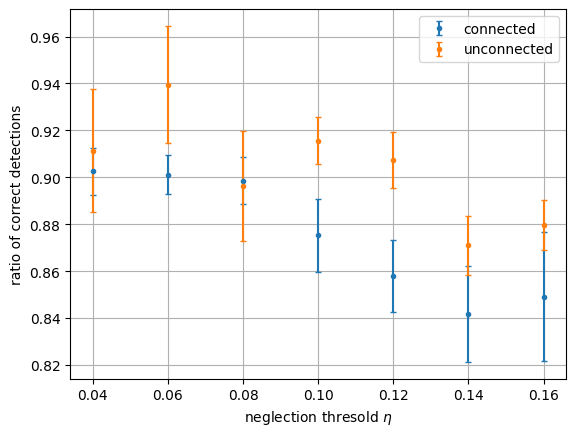

In [7]:
# Results

print(f"total number of runs per neglection thresold: {N_repeat}")
print(f"correct connected: {r_correct_connected_mean} +- {dr_mean_correct_connected}, unconnected: {r_correct_unconnected_mean} +- {dr_correct_unconnected}")

# Plotting
plt.errorbar(neglection_thres, r_correct_connected_mean, yerr=dr_mean_correct_connected, label="connected", capsize=2, ls="none", marker=".")
plt.errorbar(neglection_thres, r_correct_unconnected_mean, yerr=dr_mean_correct_unconnected, label="unconnected", capsize=2, ls="none", marker=".")
plt.xlabel(r"neglection thresold $\eta$")
plt.ylabel("ratio of correct detections")
plt.legend()
plt.grid()
plt.show()